In [89]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, make_scorer
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
df = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features.csv')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Подход 1: градиентный бустинг "в лоб"
Выполним предобработку данных:

In [21]:
df.isna().sum()

match_id                           0
start_time                         0
lobby_type                         0
r1_hero                            0
r1_level                           0
r1_xp                              0
r1_gold                            0
r1_lh                              0
r1_kills                           0
r1_deaths                          0
r1_items                           0
r2_hero                            0
r2_level                           0
r2_xp                              0
r2_gold                            0
r2_lh                              0
r2_kills                           0
r2_deaths                          0
r2_items                           0
r3_hero                            0
r3_level                           0
r3_xp                              0
r3_gold                            0
r3_lh                              0
r3_kills                           0
r3_deaths                          0
r3_items                           0
r

Пропущеные значения присутствуют в полях: 
- first_blood_time
- first_blood_team
- first_blood_player1
- first_blood_player2
- radiant_bottle_time
- radiant_courier_time
- radiant_flying_courier_time
- radiant_first_ward_time
- dire_bottle_time
- dire_courier_time
- dire_flying_courier_time
- dire_first_ward_time

Пропуски в данных объясняются следующим образом:
- Для "first_blood_time" - за первые пять минут может не произойти события "Первой крови". Это соответственно распространяется и на признаки "first_blood_team", "first_blood_player1" и "first_blood_player2". Причем заметно, что пропусков для "first_blood_player2" примерно в два раза больше, чем для "first_blood_player1". Это происходит в том случае, если игрока убила башня, при этом рядом не было противника, наносящего урон. Также возможно то, что значение просто не записалось(сбой при записи или обработке.)
- Касательно "radiant_first_ward_time" - команды не покупали варды в течение первых пяти минут. Это касается и бутылок, причем пропусков гораздо больше, так как это необязательный предмет.
- "dire_courier_time" - тут сложнее. К сожалению я не играл в Доту, но я выяснил у друзей, что курьера дают всем в начале игры. Поэтому могу предположить что это сбой в записи данных.
- "radiant_flying_courier_time" - за первые пять минут игры может произойти так, что ни один игрок не успеет докачать своего курьера до летающего.

Конечно, для всего вышеперечисленного возможны ошибки при записи или обработке значений.

Для начала попробуем способ, предложенный авторами задания - заменить все пропуски на нули.

Целевая переменная содержится в столбце "radiant_win".

Сформируем обучающую выборку. Заметим, что в исходных данных присутствуют данные, напрямую относящиеся к концу матча: длительность, состояние башен и барраков. Из за этих признаков мы будем заглядывать в будущее и переобучаться. Заметим также, что в тестовых данных эти признаки отстутствуют.

Обучим градиентный бустинг, с количеством деревьев от 10 до 100 с шагом 10 и построим график зависимости качества на кросс-валидации от числа деревьев:

Time elapsed: 0:33:50.181575
Лучший параметр: 100
Лучшее качество: 0.646


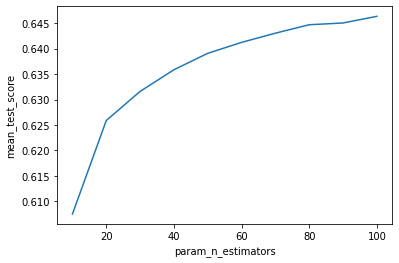

In [14]:
df = df.fillna(0)

test = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features_test.csv')
X = df.drop(columns=['radiant_win'])
diff = list(set(X.columns).difference(set(test.columns)))

X = X.drop(columns=diff)
y = df.radiant_win

params = {'n_estimators':np.arange(10,110, 10)}

cv = KFold(n_splits=5, shuffle=True)
GBC = GradientBoostingClassifier()
ROC_AUC = make_scorer(roc_auc_score)
clf = GridSearchCV(estimator=GBC, cv=cv, param_grid=params, scoring=ROC_AUC)

start_time = datetime.datetime.now()
clf.fit(X, y)
print('Time elapsed:', datetime.datetime.now() - start_time)

test_results = pd.DataFrame(clf.cv_results_)
sns.lineplot(x=test_results.param_n_estimators, y=test_results.mean_test_score)
print('Лучший параметр:', round(clf.best_params_['n_estimators'], 1))
print('Лучшее качество:', round(clf.best_score_, 3))

In [16]:
test_results.to_csv("/home/nick/results/GridSearch_100_estimators_results.csv")

In [91]:
df = df.fillna(0)

test = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features_test.csv')
X = df.drop(columns=['radiant_win'])
diff = list(set(X.columns).difference(set(test.columns)))

X = X.drop(columns=diff)
y = df.radiant_win

params = {'n_estimators':[30]}

clf_30 = GridSearchCV(estimator=GBC, cv=cv, param_grid=params, scoring=ROC_AUC)

start_time = datetime.datetime.now()
clf_30.fit(X, y)
print('Time elapsed:', datetime.datetime.now() - start_time)
test_results = pd.DataFrame(clf.cv_results_)
test_results.to_csv("GridSearch_30_results.csv")
print('Лучшее качество:', round(clf.best_score_, 3))

Time elapsed: 0:02:29.662309
Лучшее качество: 0.681


Время обучения градиентного бустинга с 30-ю деревьями: 0:02:29

По графику видно, что увеличение количества деревьев в диапазоне от 10 до 40 приводит к хорошему росту качества, но после 60 прирост становится не так заметен(с 60 до 80 он составил < 0.5%), поэтому нет особого смысла обучать алгоритм более чем на 40 деревьях.

Для того, чтобы ускорить работу градиентного бустинга, можно уменьшить время обучения отдельного дерева, например уменьшить его глубину. Также можно уменьшить размер обучающей выборки. Ещё можно избавиться от не очень важных прзнаков - например таких, как покупка предмета 'bottle'.

# Подход 2: логистическая регрессия
Выполним предобработку данных - всё также, но дополнительно отмасштабируем признаки, так как регрессия чувствительна к масштабу признаков.
Обучим линейную регрессию и подберем наилучший параметр регуляризации.

Time elapsed: 0:24:17.078248
Лучший параметр: 0.1
Лучшее качество: 0.654


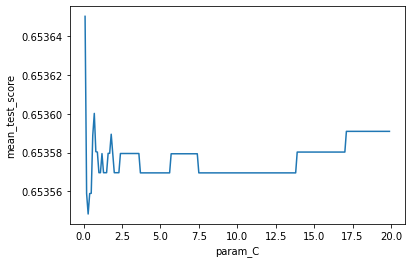

In [26]:
df = df.fillna(0)

test = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features_test.csv')
X = df.drop(columns=['radiant_win'])
diff = list(set(X.columns).difference(set(test.columns)))

X = X.drop(columns=diff)
y = df.radiant_win

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

params = {'C':np.arange(0.1,20, 0.1)}

cv = KFold(n_splits=5, shuffle=True)
LogReg = LogisticRegression(penalty='l2')
ROC_AUC = make_scorer(roc_auc_score)
clf = GridSearchCV(estimator=LogReg, cv=cv, param_grid=params, scoring=ROC_AUC)

start_time = datetime.datetime.now()
clf.fit(X, y)
print('Time elapsed:', datetime.datetime.now() - start_time)
print('Лучший параметр:', round(clf.best_params_['C'], 1))
print('Лучшее качество:', round(clf.best_score_, 3))

tests = pd.DataFrame(clf.cv_results_)
tests.to_csv("LogReg_01_20_01_results.csv")
sns.lineplot(x=tests.param_C, y=tests.mean_test_score)

Логистическая регрессия при переборе 190 вариантов параметра "С" обучается в два раза быстрее, чем градиентный бустинг, перебирающий 10 параметров деревьев, глубиной от 10 до 110.
Лучшее качество логистической регрессии - 0.654, градиентного бустинга - 0.646. Разница совсем небольшая. Можно предположить, что это происходит потому что мы работем с классами героев как с числами, а не как с метками классов. Попробуем исключить все категориальные признаки и обучить модель на таких данных.

Time elapsed: 0:19:55.714239
Лучший параметр: 0.9
Лучшее качество: 0.654


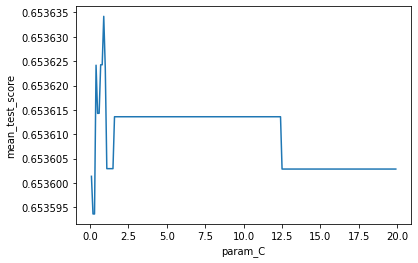

In [29]:
df = df.fillna(0)

test = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features_test.csv')
X = df.drop(columns=['radiant_win'])
diff = list(set(X.columns).difference(set(test.columns)))

X = X.drop(columns=diff)
y = df.radiant_win
drop = X.filter(regex='_hero').columns
X = X.drop(columns=drop)

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

params = {'C':np.arange(0.1,20, 0.1)}

cv = KFold(n_splits=5, shuffle=True)
LogReg = LogisticRegression(penalty='l2')
ROC_AUC = make_scorer(roc_auc_score)
clf = GridSearchCV(estimator=LogReg, cv=cv, param_grid=params, scoring=ROC_AUC)

start_time = datetime.datetime.now()
clf.fit(X, y)
print('Time elapsed:', datetime.datetime.now() - start_time)
print('Лучший параметр:', round(clf.best_params_['C'], 1))
print('Лучшее качество:', round(clf.best_score_, 3))

tests = pd.DataFrame(clf.cv_results_)
tests.to_csv("LogReg_01_20_01_no_champ_results.csv")
sns.lineplot(x=tests.param_C, y=tests.mean_test_score)

Качество предсказаний осталось тем же. По всей видимости, нет разницы в том, присутствуют ли данные о героях, или нет - пока герои не представлены отдельными признаками, алгоритм слабо учитывает их.
Изменим подход - оставим данные о героях, сформируем признаки при помощи "мешка слов":

In [30]:
print(df.filter(regex='_hero').nunique())
un_val = df.filter(regex='_hero')
for col in un_val:
    print(sorted(un_val[col].unique()))

r1_hero    108
r2_hero    108
r3_hero    108
r4_hero    108
r5_hero    108
d1_hero    108
d2_hero    108
d3_hero    108
d4_hero    108
d5_hero    108
dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 109, 110, 112]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,

Всего у нас 108 различных героев, но можно заметить, что многие порядковые номера пропущены, максимальный номер равен 112. Сделаем датафрейм с чемпионами чуть больше, затем уберем пустые колонки.

(97230, 108)
(97230, 103)
(97230, 211)
Time elapsed: 0:38:21.707184
Лучший параметр: 0.1
Лучшее качество: 0.681


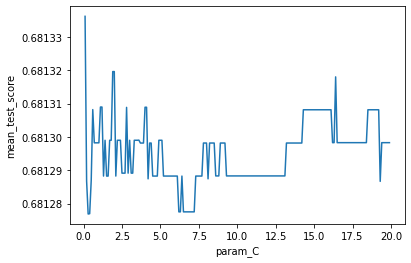

In [36]:
df = df.fillna(0)

test = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features_test.csv')
X = df.drop(columns=['radiant_win'])
diff = list(set(X.columns).difference(set(test.columns)))

X = X.drop(columns=diff)
y = df.radiant_win

N = 113 #героев 108, но некоторые пропущены, наибольший номер - 112
X_pick = np.empty((df.shape[0], N))
X_pick[:] = np.nan

for i, match_id in enumerate(df.index):
    for p in range(5):
        X_pick[i, df.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, df.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick = pd.DataFrame(X_pick)
empty_cols = [col for col in X_pick.columns if X_pick[col].isna().all()]
X_pick = X_pick.drop(columns=empty_cols).fillna(0)

print(X_pick.shape)
print(X.shape)
X = pd.concat([X, X_pick], axis=1)
print(X.shape)  #Проверим, что мы ничего не потеряли

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

params = {'C':np.arange(0.1,20, 0.1)}

cv = KFold(n_splits=5, shuffle=True)
LogReg = LogisticRegression(penalty='l2')
ROC_AUC = make_scorer(roc_auc_score)
clf = GridSearchCV(estimator=LogReg, cv=cv, param_grid=params, scoring=ROC_AUC)

start_time = datetime.datetime.now()
clf.fit(X, y)
print('Time elapsed:', datetime.datetime.now() - start_time)
tests = pd.DataFrame(clf.cv_results_)
sns.lineplot(x=tests.param_C, y=tests.mean_test_score)
print('Лучший параметр:', round(clf.best_params_['C'], 1))
print('Лучшее качество:', round(clf.best_score_, 3))

tests.to_csv("LogReg_01_20_01_w_champ_results.csv")

Качество улучшилось, так как стали учитываться герои, которые различаются по способностям и, следовательно, влияют на результат матча. 
Качество этой модели - наивысшее из всех испробованных. Её и будем использовать на тестовой выборке.

In [39]:
best_LogReg = clf.best_estimator_
best_LogReg.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
test_data = pd.read_csv('/home/nick/study/coursera/data/Kaggle/Dota/features_test.csv')

X = test_data
X = X.fillna(0)
N = 113 #героев 108, но некоторые пропущены, наибольший номер - 112
X_pick = np.empty((X.shape[0], N))
X_pick[:] = np.nan

for i, match_id in enumerate(X.index):
    for p in range(5):
        X_pick[i, df.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, df.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
X_pick = pd.DataFrame(X_pick)
empty_cols = [col for col in X_pick.columns if X_pick[col].isna().all()]
X_pick = X_pick.drop(columns=empty_cols).fillna(0)

print(X_pick.shape)
print(X.shape)
X = pd.concat([X, X_pick], axis=1)
print(X.shape)

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y_pred_prob = np.array(best_LogReg.predict_proba(X))
y_pred = np.array(best_LogReg.predict(X))
predictions = []
for i in range(len(y_pred)):
    predictions.append([y_pred[i], max(y_pred_prob[i])])
predictions_data = pd.DataFrame(predictions, columns=['radiant_win', 'probability'])

(17177, 108)
(17177, 103)
(17177, 211)


In [87]:
print('Минимальное значение: победит команда Dire с вероятностью {}'.format(predictions_data.sort_values(by='probability').iloc[1].probability))
print('Максимальное значение: победит команда Radiant с вероятностью {}'.format(predictions_data.sort_values(by='probability', ascending=False).iloc[1].probability))

Минимальное значение: победит команда Dire с вероятностью 0.5000217891809744
Максимальное значение: победит команда Radiant с вероятностью 0.9958799652621109
